In [1]:
import pandas as pd
import math
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing, svm, neighbors
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
#import tensorflow_addons as tfa

2023-08-16 15:46:21.142791: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-16 15:46:22.423072: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /N/soft/rhel7/netcdf_c/intel/serial/4.4.1.1/lib:/N/soft/rhel7/curl/intel/7.54.0/lib:/N/soft/rhel7/hdf5/intel/serial/1.10.1/lib:/N/soft/rhel7/zlib/gnu/1.2.13/lib:/N/soft/rhel7/szip/intel/2.1.1/lib:/N/soft/rhel7/libpng/1.6.29/lib:/N/soft/rhel7/jasper/gnu/1.900.1/lib:/N/soft/rhel7/openmpi/intel/4.0.1/lib:/N/soft/rhel7/intel/19.5/compilers_and_libraries_2019.5.281/linux/compiler/lib/intel64:/N/soft/rhel7/intel/19.5/compilers_and_libraries_2019.5.281/linux/ip

In [2]:
#
# build an F1-score function for later use
#
def F1_score(y_true,y_prediction,true_class,true_threshold):
    T = len(y_true)
    if len(y_prediction) != T:
        print("Prediction and true label arrays have different size. Stop")
        return
    P = 0
    TP = 0 
    FN = 0
    TN = 0
    FP = 0
    for i in range(T):
        if y_true[i] == true_class:
            P = P + 1       
            if y_prediction[i] >= true_threshold:
                TP += 1 
            else:
                FN += 1
        else:
            if y_prediction[i] >= true_threshold:
                FP += 1 
            else:
                TN += 1            
    N = T - P    
    F1 = 2.*TP/(2.*TP + FP + FN)
    Recall = TP/float(TP+FN)
    if TP == 0 and FP == 0: 
        Precision = 0.
    else:    
        Precision = TP/float(TP+FP)
    return F1, Recall, Precision

In [3]:
#
# reading all input data, and replace/remove bad data. Note that this data set
# must contain the last column "class" that indicates RI (1) or non-RI (0). Note that
# option flag_input_more_time denotes a single time slice, or mutiple time slices from
# SHIP forecasts.
#
flag_input_future_time="00h"       # 00h, 12h, or 24h
good_input = "yes"
df = pd.read_csv('/N/u/ckieu/Carbonate/python/SHIP_allbasin_2011_2022_Version3(+24hr).csv')
if flag_input_future_time == "12h":
    df.drop(['Storm','OHC','OHC(+6h)','OHC(+12h)','OHC(+18h)','OHC(+24h)'], axis=1, inplace=True)
elif flag_input_future_time == "24h":
    df.drop(['Storm','OHC','OHC(+6h)','OHC(+12h)','OHC(+18h)','OHC(+24h)'], axis=1, inplace=True)
elif flag_input_future_time == "00h":
    df.drop(['Storm','OHC','OHC(+6h)','OHC(+12h)','OHC(+18h)','OHC(+24h)',
             'lat(+6h)','lat(+12h)','lat(+18h)','lat(+24h)',
             'lon(+6h)','lon(+12h)','lon(+18h)','lon(+24h)',
             'MaxWind(+6h)','MaxWind(+12h)','MaxWind(+18h)','MaxWind(+24h)',
             'RMW(+6h)','RMW(+12h)','RMW(+18h)','RMW(+24h)',
             'MIN_SLP(+6hr)','MIN_SLP(+12hr)','MIN_SLP(+18h)','MIN_SLP(+24h)',
             'SHR_MAG(+6h)','SHR_MAG(+12h)','SHR_MAG(+18h)','SHR_MAG(+24h)',
             'SHR_HDG(+6h)','SHR_HDG(+12h)','SHR_HDG(+18h)','SHR_HDG(+24h)',
             'STM_SPD(+6h)','STM_SPD(+12h)','STM_SPD(+18h)','STM_SPD(+24h)',
             'STM_HDG(+6h)','STM_HDG(+12h)','STM_HDG(+18h)','STM_HDG(+24h)',
             'SST(+6h)','SST(+12h)','SST(+18h)','SST(+24h)',
             'TPW(+6h)','TPW(+12h)','TPW(+18h)','TPW(+24h)',
             'LAND(+6h)','LAND(+12h)','LAND(+18h)','LAND(+24h)',
             '850TANG(+6h)','850TANG(+12h)','850TANG(+18h)','850TANG(+24h)',
             '850VORT(+6h)','850VORT(+12h)','850VORT(+18h)','850VORT(+24h)',
             '200DVRG(+6h)','200DVRG(+12h)','200DVRG(+18h)','200DVRG(+24h)'], axis=1, inplace=True)
else:
    print("flag_input_future_time is not correctly set. Stop")
    good_input = "no"

if good_input == "yes":
    df.replace('?',-99999, inplace=True)
    print(df.head(3))
    x = np.array(df.drop(['class'],axis=1)).astype("float32")
    y = np.array(df['class']).astype("float32")
    print(x[0],y[0])
    print("Data length of data frame df variable is ",len(df))
    

    lat    lon  MaxWind  RMW  MIN_SLP  SHR_MAG  SHR_HDG  STM_SPD  STM_HDG  \
0  28.6  282.5       44   65      994       36       86       15       59   
1  29.9  285.1       50  120      993       31       84       22       49   
2  30.9  287.5       56  163      991       34       86       23       53   

   SST  TPW  LAND  850TANG  850VORT  200DVRG  class  
0  263   48   301      138       32       99      0  
1  260   50   541      154       26       79      0  
2  262   51   572      172       40       97      0  
[ 28.6 282.5  44.   65.  994.   36.   86.   15.   59.  263.   48.  301.
 138.   32.   99. ] 0.0
Data length of data frame df variable is  4285


In [4]:
#
# produce a simple reference forecast by randomly sampling the y array and check how many 
# of the random_label matches the y array. That is, if y[i] = random_label_copy[y], then
# hits_array[i] = 1, else hits_array[i] = 0.
#
import copy
random_label_copy = copy.copy(y)
print(random_label_copy[0:50])
np.random.shuffle(random_label_copy)
print(random_label_copy[0:50])
hits_array = np.array(y) == np.array(random_label_copy)
#print(hits_array)
print(f"Reference forecast by random sampling the y label gives an accuracy (RI or non-RI) of: {hits_array.mean():.3f}")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0.]
Reference forecast by random sampling the y label gives an accuracy (RI or non-RI) of: 0.849


In [5]:
#
# Create a first simple model for RI forecast, using the logistic regression method. Note the 
# difference between "binary_accuracy" and "accuracy" metrics as mentioned in 
# https://keras.io/api/metrics/accuracy_metrics/. 
# - binary_accuracy: compare two real numbers to see if they match above a given threshold
# - accuracy: compare two integer numbers to see if they match.
# 
x1_train, x1_test, y1_train, y1_test = train_test_split(x, y, test_size=0.1)
print("Total train and test data sizes are: ", x1_train.shape,x1_test.shape,y1_train.shape,y1_test.shape)
validation_split = np.int(0.1*len(x1_train))
x2_val = x1_train[:validation_split]
y2_val = y1_train[:validation_split]
x2_train = x1_train[validation_split:]
y2_train = y1_train[validation_split:]
print("Train and validation data sizes are: ", x2_train.shape,x2_val.shape,y2_train.shape,y2_val.shape)

model_logistics = keras.Sequential([layers.Dense(32, activation = "relu"),
                                    layers.Dense(32, activation = "relu"),
                                    layers.Dense(1, activation = "sigmoid")])
#
# Two options for metrics here: accuracy or binary_accuracy
#
#model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])
callbacks = [keras.callbacks.ModelCheckpoint("RI_model_logistics_00h.keras",save_best_only=True)]
model_logistics.compile(optimizer="rmsprop",loss="binary_crossentropy",
                        metrics=[tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.8)])
history_logistics = model_logistics.fit(x2_train,y2_train,epochs=50,batch_size=16,validation_data=(x2_val,y2_val),
                                       callbacks=callbacks)

Total train and test data sizes are:  (3856, 15) (429, 15) (3856,) (429,)
Train and validation data sizes are:  (3471, 15) (385, 15) (3471,) (385,)


/tmp/ipykernel_32090/4240013663.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  validation_split = np.int(0.1*len(x1_train))
2023-08-16 15:48:41.036915: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /N/soft/rhel7/netcdf_c/intel/serial/4.4.1.1/lib:/N/soft/rhel7/curl/intel/7.54.0/lib:/N/soft/rhel7/hdf5/intel/serial/1.10.1/lib:/N/soft/rhel7/zlib/gnu/1.2.13/lib:/N/soft/rhel7

Epoch 1/50
217/217 [==============================] - 2s 2ms/step - loss: 9.7418 - binary_accuracy: 0.8557 - val_loss: 6.7345 - val_binary_accuracy: 0.9013
Epoch 2/50
217/217 [==============================] - 0s 1ms/step - loss: 3.6751 - binary_accuracy: 0.8606 - val_loss: 4.5408 - val_binary_accuracy: 0.9013
Epoch 3/50
217/217 [==============================] - 0s 1ms/step - loss: 2.9814 - binary_accuracy: 0.8637 - val_loss: 3.4820 - val_binary_accuracy: 0.9013
Epoch 4/50
217/217 [==============================] - 0s 1ms/step - loss: 2.8603 - binary_accuracy: 0.8727 - val_loss: 2.5225 - val_binary_accuracy: 0.8909
Epoch 5/50
217/217 [==============================] - 0s 1ms/step - loss: 2.6008 - binary_accuracy: 0.8695 - val_loss: 1.8480 - val_binary_accuracy: 0.9013
Epoch 6/50
217/217 [==============================] - 0s 1ms/step - loss: 2.3188 - binary_accuracy: 0.8764 - val_loss: 2.7616 - val_binary_accuracy: 0.9013
Epoch 7/50
217/217 [==============================] - 0s 1ms/ste

14/14 [==============================] - 0s 922us/step - loss: 0.4055 - binary_accuracy: 0.9277
Evalution results (loss,accuracy) for the test data is  [0.4055465757846832, 0.9277389049530029]
14/14 [==============================] - 0s 770us/step
F1, Recall, Precision for logistic model are: (0.2541436464088398, 0.7419354838709677, 0.15333333333333332)


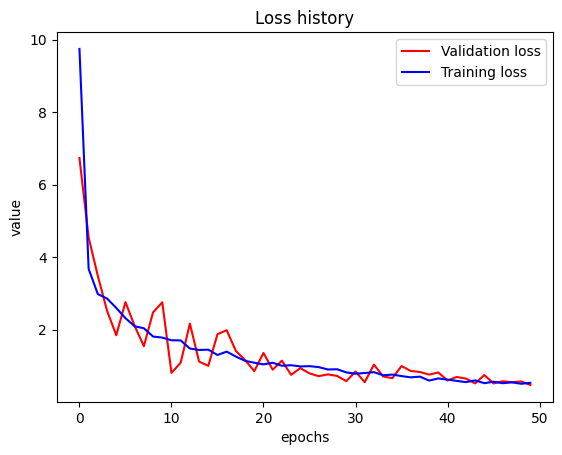

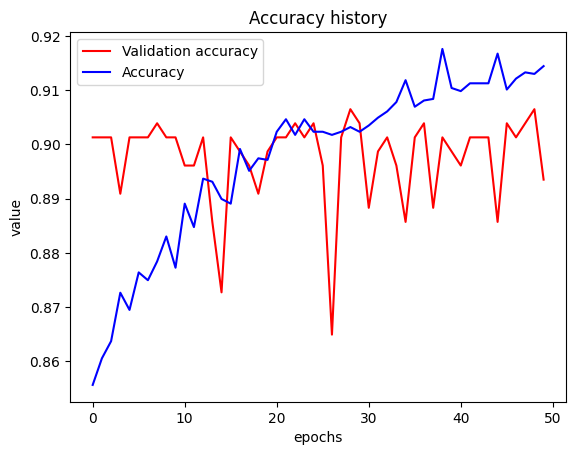

In [6]:
#
# check F1 score for the logistic model with the internal test data
#
results = model_logistics.evaluate(x1_test,y1_test)
print("Evalution results (loss,accuracy) for the test data is ",results)
single_fcst = model_logistics.predict(x1_test)
print("F1, Recall, Precision for logistic model are:",F1_score(y1_test,single_fcst,1,0.10))  
#
# plotting the performance of the logistics regression
#
import matplotlib.pyplot as plt
#print(history_logistics.__dict__)
epochs = history_logistics.epoch
val_loss = history_logistics.history['val_loss']
loss = history_logistics.history['loss']
plt.plot(epochs,val_loss,'r',label="Validation loss")
plt.xlabel("epochs")
plt.ylabel("value")
plt.title("Loss history")
plt.plot(epochs,loss,'b',label="Training loss")
plt.legend()
plt.show()

plt.clf()
val_accuracy = history_logistics.history['val_binary_accuracy']
accuracy = history_logistics.history['binary_accuracy']
plt.plot(epochs,val_accuracy,'r',label="Validation accuracy")
plt.xlabel("epochs")
plt.ylabel("value")
plt.title("Accuracy history")
plt.plot(epochs,accuracy,'b',label="Accuracy")
plt.legend()
plt.show()

In [7]:
#
# create input data for RNN by reshaping the input data into a new tensor of the dimension
# (num_sample, num_times, num_predictors). Note that using the metric=accuracy returns very bad
# accuracy < 0.1
# 
if flag_input_future_time == "24h":
    sequence_length = 5
elif flag_input_future_time == "12h":
    sequence_length = 3
elif flag_input_future_time == "00h":
    sequence_length = 1    
num_predictors = 15
print("Train/val data sizes before reshape are: ", x2_train.shape,x2_val.shape,y2_train.shape,y2_val.shape)
x3_val = x2_val.reshape((-1,sequence_length,num_predictors))
x3_train = x2_train.reshape((-1,sequence_length,num_predictors))
test_dataset = x1_test.reshape((-1,sequence_length,num_predictors))
print("New train/validation data sizes for RNN are: ", x3_train.shape,x3_val.shape, test_dataset.shape)
print(x2_val[0])
print(x3_val[0])

Train/val data sizes before reshape are:  (3471, 15) (385, 15) (3471,) (385,)
New train/validation data sizes for RNN are:  (3471, 1, 15) (385, 1, 15) (429, 1, 15)
[  30.4  286.5   63.   130.  1000.    19.   129.    18.     5.   280.
   51.   564.    68.   -39.   127. ]
[[  30.4  286.5   63.   130.  1000.    19.   129.    18.     5.   280.
    51.   564.    68.   -39.   127. ]]


In [9]:
#
# Build first an RNN model for RI prediction to see how it compares to the simple logistic regression
# model, using the newly-formatted data
#
inputs = keras.Input(shape=(sequence_length,num_predictors))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(1,activation = "sigmoid")(x)
model_RNN = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("RI_model_RNN_00h.keras",save_best_only=True)]
model_RNN.compile(optimizer="rmsprop",loss="mse",
                  metrics=[tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.2)])
history_RNN = model_RNN.fit(x3_train, y2_train, epochs=50, batch_size=64, 
                             validation_data=(x3_val, y2_val), callbacks=callbacks)

model_best = keras.models.load_model("RI_model_RNN_00h.keras")
print(f"The best trained RNN prediction error is: {model_best.evaluate(test_dataset,y1_test)[1]:.3f}")
print(f"The last trained RNN prediction error is: {model_RNN.evaluate(test_dataset,y1_test)[1]:.3f}")

Epoch 1/50
55/55 [==============================] - 2s 7ms/step - loss: 0.1232 - binary_accuracy: 0.5791 - val_loss: 0.0961 - val_binary_accuracy: 0.7818
Epoch 2/50
55/55 [==============================] - 0s 2ms/step - loss: 0.0797 - binary_accuracy: 0.8534 - val_loss: 0.0897 - val_binary_accuracy: 0.8805
Epoch 3/50
55/55 [==============================] - 0s 2ms/step - loss: 0.0759 - binary_accuracy: 0.9127 - val_loss: 0.0904 - val_binary_accuracy: 0.9013
Epoch 4/50
55/55 [==============================] - 0s 2ms/step - loss: 0.0755 - binary_accuracy: 0.9165 - val_loss: 0.0887 - val_binary_accuracy: 0.9013
Epoch 5/50
55/55 [==============================] - 0s 2ms/step - loss: 0.0748 - binary_accuracy: 0.9182 - val_loss: 0.0882 - val_binary_accuracy: 0.9013
Epoch 6/50
55/55 [==============================] - 0s 2ms/step - loss: 0.0745 - binary_accuracy: 0.9182 - val_loss: 0.0880 - val_binary_accuracy: 0.9013
Epoch 7/50
55/55 [==============================] - 0s 2ms/step - loss: 0.07

14/14 [==============================] - 0s 1ms/step
F1, Recall, Precision for RNN model are: (0.1645021645021645, 0.6129032258064516, 0.095)


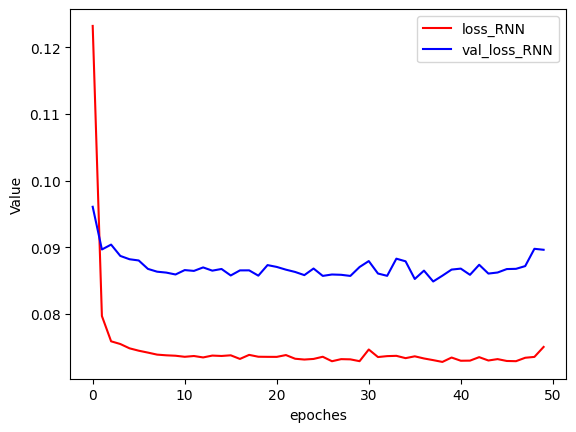

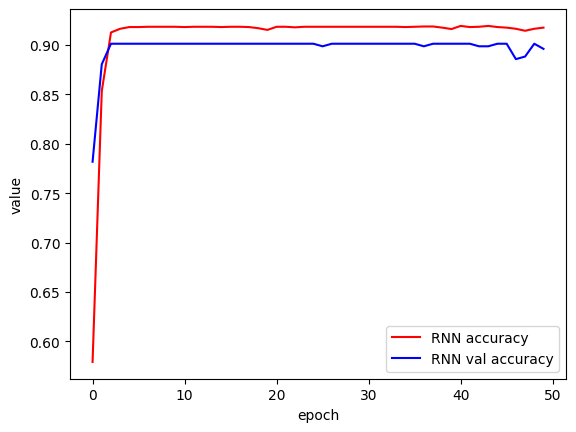

In [10]:
#
# Check F1 score now for the RNN model
#
y_prediction = model_RNN.predict(test_dataset)
#print(model_best.evaluate(test_dataset,y1_test))
#print(y_prediction[398],y1_test,len(y1_test))
print("F1, Recall, Precision for RNN model are:",F1_score(y1_test,y_prediction,1,0.07))
#
# ploting the performance of the RNN model
#
epoch = history_RNN.epoch
val_loss_RNN = history_RNN.history['val_loss'] 
loss_RNN = history_RNN.history['loss']
plt.plot(epoch,loss_RNN,'r',label="loss_RNN")
plt.xlabel("epoches")
plt.ylabel("Value")
plt.plot(epoch,val_loss_RNN,'b',label="val_loss_RNN")
plt.legend()
plt.show()

accuracy_RNN = history_RNN.history['binary_accuracy']
val_accuracy_RNN = history_RNN.history['val_binary_accuracy']
plt.plot(epoch,accuracy_RNN,'r',label="RNN accuracy")
plt.plot(epoch,val_accuracy_RNN,'b',label="RNN val accuracy")
plt.xlabel("epoch")
plt.ylabel("value")
plt.legend()
plt.show()

In [11]:
#
# Now, lets try to use GRU method to see how it performs as compared to the RNN
#
inputs = keras.Input(shape=(sequence_length,num_predictors))
x = layers.GRU(16, return_sequences=True)(inputs)
x = layers.GRU(16, return_sequences=True)(x)
outputs = layers.GRU(1,activation = "sigmoid")(x)
model_GRU = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("RI_model_GRU_00h.keras",save_best_only=True)]
model_GRU.compile(optimizer="rmsprop",loss="mse",
                  metrics=[tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.2)])
history_GRU = model_GRU.fit(x3_train, y2_train, epochs=50, batch_size=64, 
                             validation_data=(x3_val, y2_val), callbacks=callbacks)

model_best = keras.models.load_model("RI_model_GRU_00h.keras")
print(f"The best trained GRU prediction error is: {model_best.evaluate(test_dataset,y1_test)[1]:.3f}")
print(f"The last trained GRU prediction error is: {model_GRU.evaluate(test_dataset,y1_test)[1]:.3f}")

Epoch 1/50
55/55 [==============================] - 4s 15ms/step - loss: 0.0789 - binary_accuracy: 0.8741 - val_loss: 0.0886 - val_binary_accuracy: 0.9013
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.0746 - binary_accuracy: 0.9185 - val_loss: 0.0881 - val_binary_accuracy: 0.9013
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.0743 - binary_accuracy: 0.9185 - val_loss: 0.0877 - val_binary_accuracy: 0.9013
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.0740 - binary_accuracy: 0.9185 - val_loss: 0.0875 - val_binary_accuracy: 0.9013
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.0740 - binary_accuracy: 0.9185 - val_loss: 0.0879 - val_binary_accuracy: 0.9013
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.0738 - binary_accuracy: 0.9185 - val_loss: 0.0881 - val_binary_accuracy: 0.9013
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.0

14/14 [==============================] - 1s 1ms/step
F1, Recall, Precision for GRU model are: (0.16181229773462782, 0.8064516129032258, 0.08992805755395683)


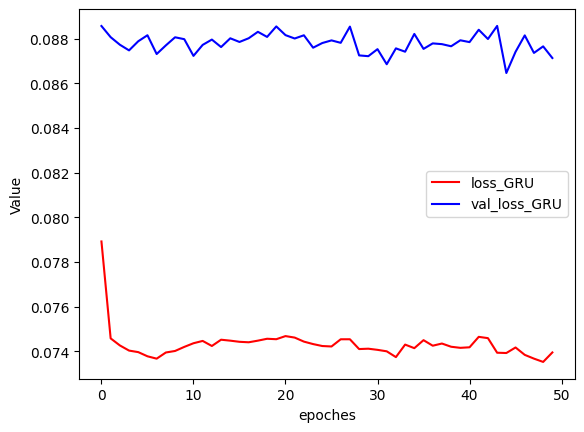

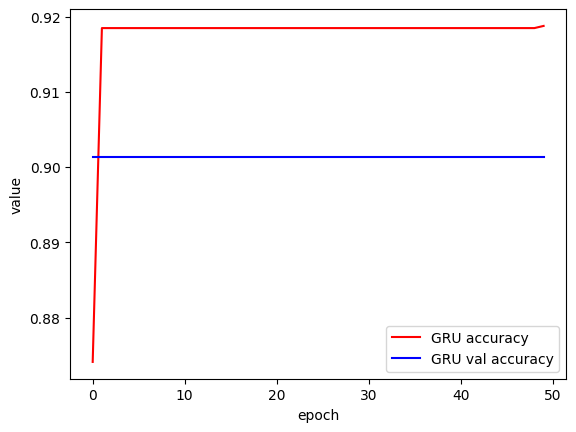

In [12]:
#
# Check F1 score now for the GRU model
#
y_prediction = model_GRU.predict(test_dataset)
print("F1, Recall, Precision for GRU model are:",F1_score(y1_test,y_prediction,1,0.07))
#
# ploting the performance of the RNN model
#
epoch = history_GRU.epoch
val_loss_GRU = history_GRU.history['val_loss'] 
loss_GRU = history_GRU.history['loss']
plt.plot(epoch,loss_GRU,'r',label="loss_GRU")
plt.xlabel("epoches")
plt.ylabel("Value")
plt.plot(epoch,val_loss_GRU,'b',label="val_loss_GRU")
plt.legend()
plt.show()

accuracy_GRU = history_GRU.history['binary_accuracy']
val_accuracy_GRU = history_GRU.history['val_binary_accuracy']
plt.plot(epoch,accuracy_GRU,'r',label="GRU accuracy")
plt.plot(epoch,val_accuracy_GRU,'b',label="GRU val accuracy")
plt.xlabel("epoch")
plt.ylabel("value")
plt.legend()
plt.show()

In [14]:
#
# loading three different pre-trained models using all 24-h input SHIP data
#
df = pd.read_csv('/N/u/ckieu/Carbonate/python/DOKSURI05W_Master.csv')
df.drop(['Time','Basin','OHC','OHC(+6h)','OHC(+12h)','OHC(+18h)','OHC(+24h)'], axis=1, inplace=True)
df.replace('?',-99999, inplace=True)
x_fcst = np.array(df.drop(['Storm','class'],axis=1))
y_true = np.array(df['class'])
print('External input SHIP data length is: ',len(x_fcst))
print(y_true)
x_0d = np.array(df[['lat','lon','MaxWind','RMW','MIN_SLP','SHR_MAG','SHR_HDG','STM_SPD','STM_HDG',
                   'SST','TPW','LAND','850TANG','850VORT','200DVRG']])
x_0d_extent = np.expand_dims(x_0d, axis=1)
print(x_0d.shape,x_0d_extent.shape)
model_RNN_0d = keras.models.load_model("RI_model_RNN_00h.keras")
model_logistics_0d = keras.models.load_model("RI_model_logistics_00h.keras")
model_GRU_0d = keras.models.load_model("RI_model_GRU_00h.keras")
fcst_logistics_0d = model_logistics_0d.predict(x_0d)
fcst_GRU_0d = model_GRU_0d.predict(x_0d_extent)
fcst_RNN_0d = model_RNN_0d.predict(x_0d_extent)
for i in range(len(x_fcst)):
    print(f"Logistic, RNN, GRU probability predictions 00h: {float(fcst_logistics_0d[i]):.3f},{float(fcst_RNN_0d[i]):.3f},{float(fcst_GRU_0d[i]):.3f}")
print("F1, Recall, Precision for logistics model are:",F1_score(y_true,fcst_logistics_0d,1,0.3))    
print("F1, Recall, Precision for RNN model are:",F1_score(y_true,fcst_RNN_0d,1,0.3))    
print("F1, Recall, Precision for GRU model are:",F1_score(y_true,fcst_GRU_0d,1,0.3))    

External input SHIP data length is:  24
[1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(24, 15) (24, 1, 15)
1/1 [==============================] - 0s 229ms/step
Logistic, RNN, GRU probability predictions 00h: 0.515,0.048,0.092
Logistic, RNN, GRU probability predictions 00h: 0.628,0.048,0.094
Logistic, RNN, GRU probability predictions 00h: 0.698,0.048,0.080
Logistic, RNN, GRU probability predictions 00h: 0.329,0.048,0.080
Logistic, RNN, GRU probability predictions 00h: 0.115,0.048,0.094
Logistic, RNN, GRU probability predictions 00h: 0.026,0.048,0.082
Logistic, RNN, GRU probability predictions 00h: 0.314,0.103,0.080
Logistic, RNN, GRU probability predictions 00h: 0.257,0.103,0.080
Logistic, RNN, GRU probability predictions 00h: 0.169,0.048,0.080
Logistic, RNN, GRU probability predictions 00h: 0.066,0.048,0.080
Logistic, RNN, GRU probability predictions 00h: 0.032,0.048,0.080
Logistic, RNN, GRU probability predictions 00h: 0.004,0.048,0.080
Logistic, RNN, GRU probability predictions 0